This notebook is made to explore ways to take an existing sleap project and perform preprocessing on the frames to make tracking easier

In [124]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Testing preprocessing options on an example video

In [24]:
def extract_frame(video_path):
    """Extract the last frame from the video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Move to the last frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1)

    # Read the last frame
    ret, frame = cap.read()
    if not ret:
        print(f"Error: Could not read frame from video {video_path}")
        return None

    cap.release()
    return frame

def generate_grid(folder_path, preview=False, overwrite=False):
    folder_path = Path(folder_path)

    # print(f"Generating grid image for {folder_path.name}")

    frames = []
    paths = []

    # Iterate over all video files in the folder
    for video_file in folder_path.rglob("*.mp4"):  # Adjust the pattern if needed
        frame = extract_frame(video_file)
        if frame is not None:
            frames.append(frame)
            paths.append(video_file)

    return frames, paths

def plot_grid(frames, paths):
    # Set the number of rows and columns for the grid
    nrows = 9
    ncols = 6

    # Create a figure with subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))

    # Loop over the frames and video paths
    for i, (frame, video_path) in enumerate(zip(frames, paths)):
        # Get the row and column index for this subplot
        row = i // ncols
        col = i % ncols

        # Plot the frame on this subplot
        try:
            axs[row, col].imshow(frame, cmap="gray", vmin=0, vmax=255)
        except:
            print(f"Error: Could not plot frame {i} for video {video_path}")
            continue

    # Remove the axis of each subplot and draw them closer together
    for ax in axs.flat:
        ax.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()

In [25]:
frames, paths = generate_grid("/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231205_TNT_Fine_1_Videos_Tracked")

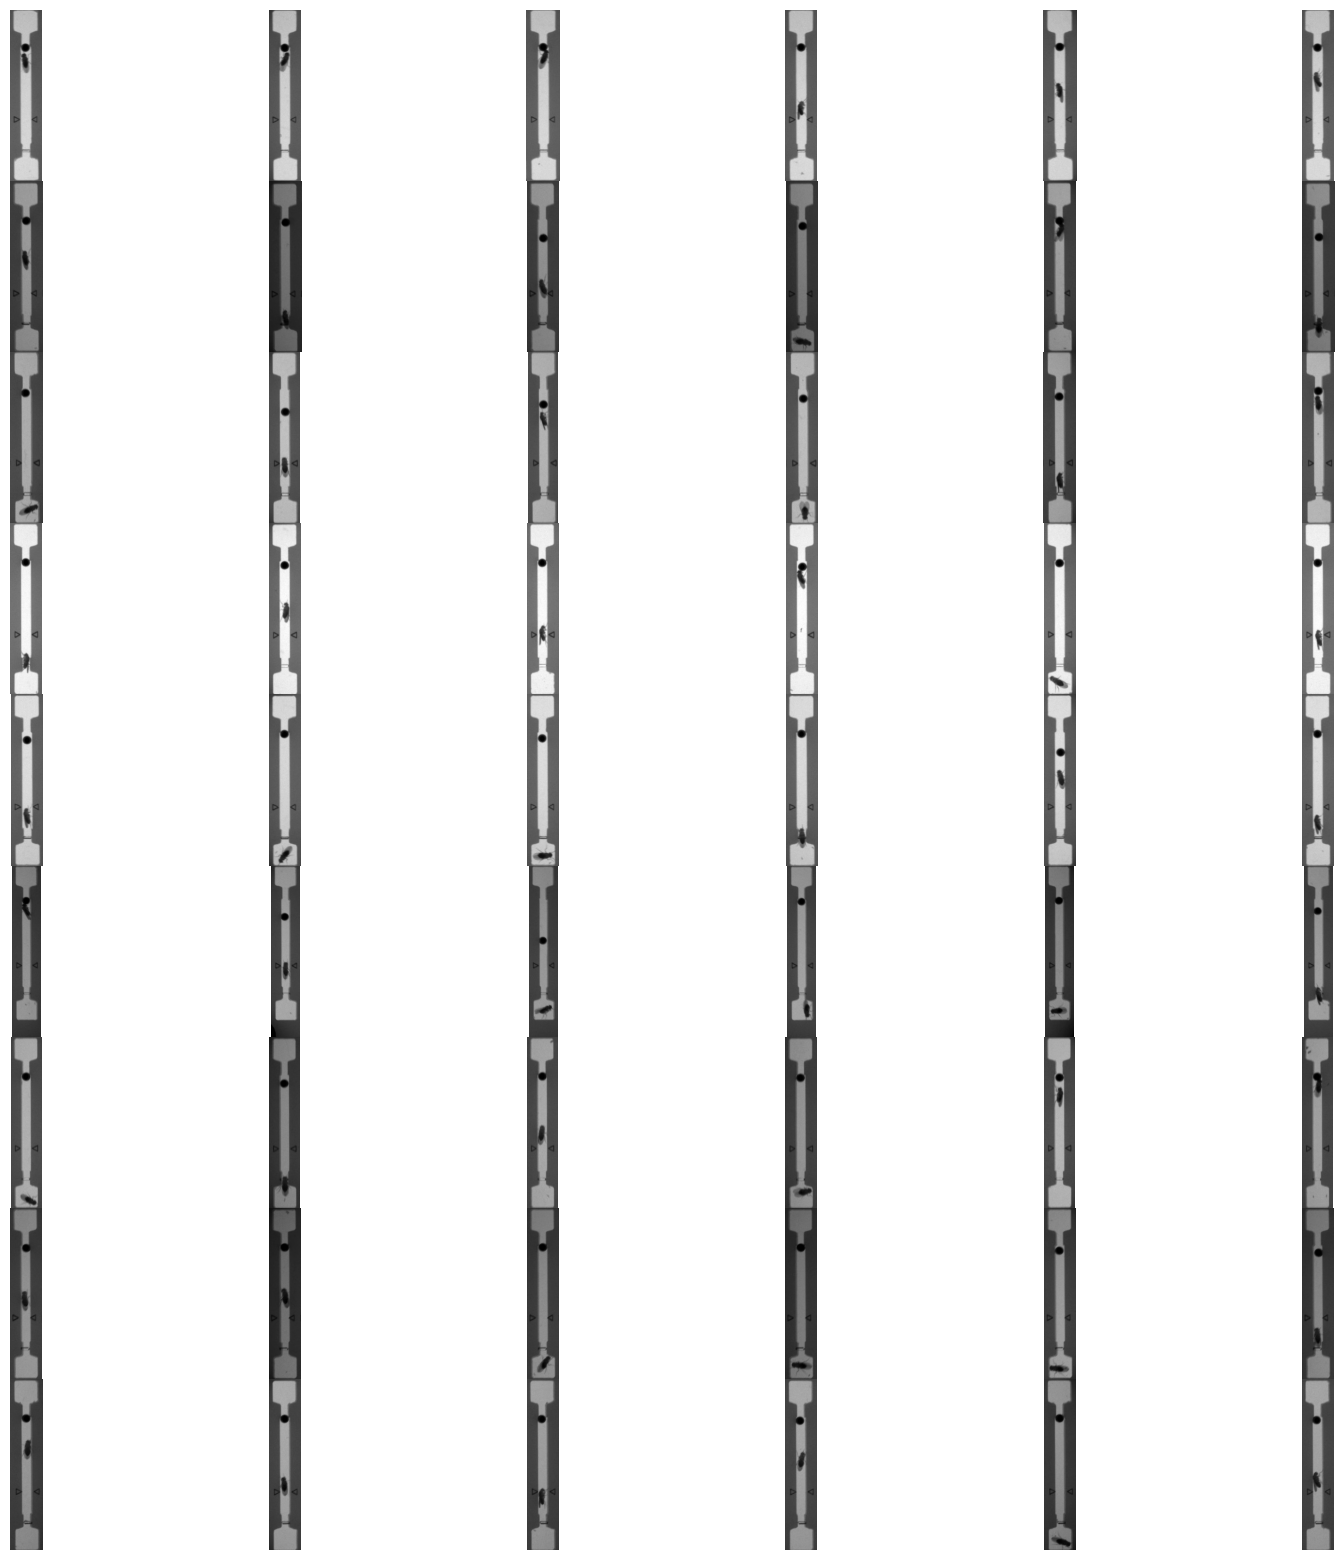

In [26]:
plot_grid(frames, paths)

In [27]:
# Now let's apply histogram equalization over the frames


def compute_global_histogram(frames):
    """Compute the global histogram for all frames."""
    global_hist = np.zeros(256, dtype=np.float32)
    for frame in frames:
        if len(frame.shape) == 3:  # Convert to grayscale if needed
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([frame], [0], None, [256], [0, 256])
        global_hist += hist.flatten()
    return global_hist


def compute_global_cdf(global_hist):
    """Compute the global CDF from the global histogram."""
    cdf = global_hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]  # Normalize to [0, 255]
    return cdf_normalized


def apply_global_histogram_equalization(frame, global_cdf):
    """Apply global histogram equalization to a single frame."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    equalized_frame = cv2.LUT(frame, global_cdf.astype(np.uint8))
    return equalized_frame

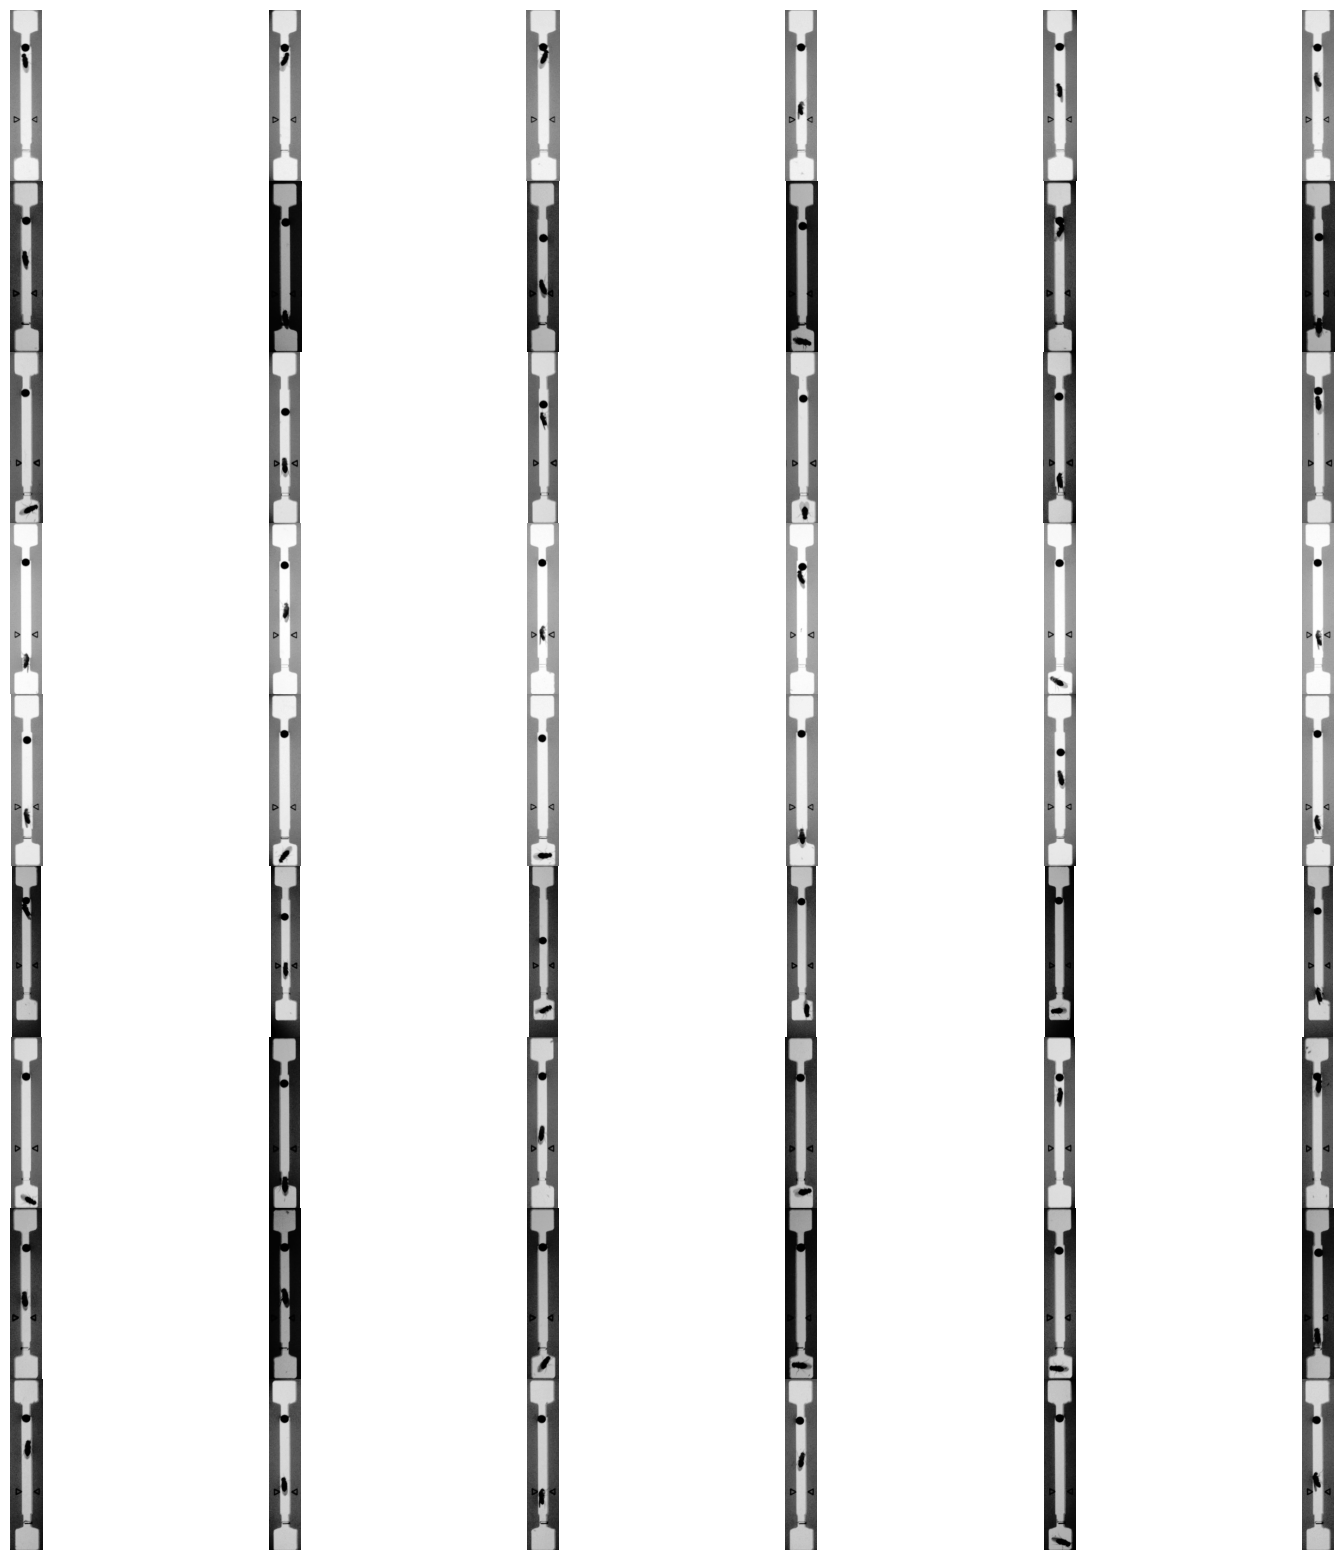

In [28]:
# Compute the global histogram and CDF
global_hist = compute_global_histogram(frames)
global_cdf = compute_global_cdf(global_hist)

# Apply global histogram equalization to each frame
equalized_frames = [
    apply_global_histogram_equalization(frame, global_cdf) for frame in frames
]

# Plot the equalized grid
plot_grid(equalized_frames, paths)

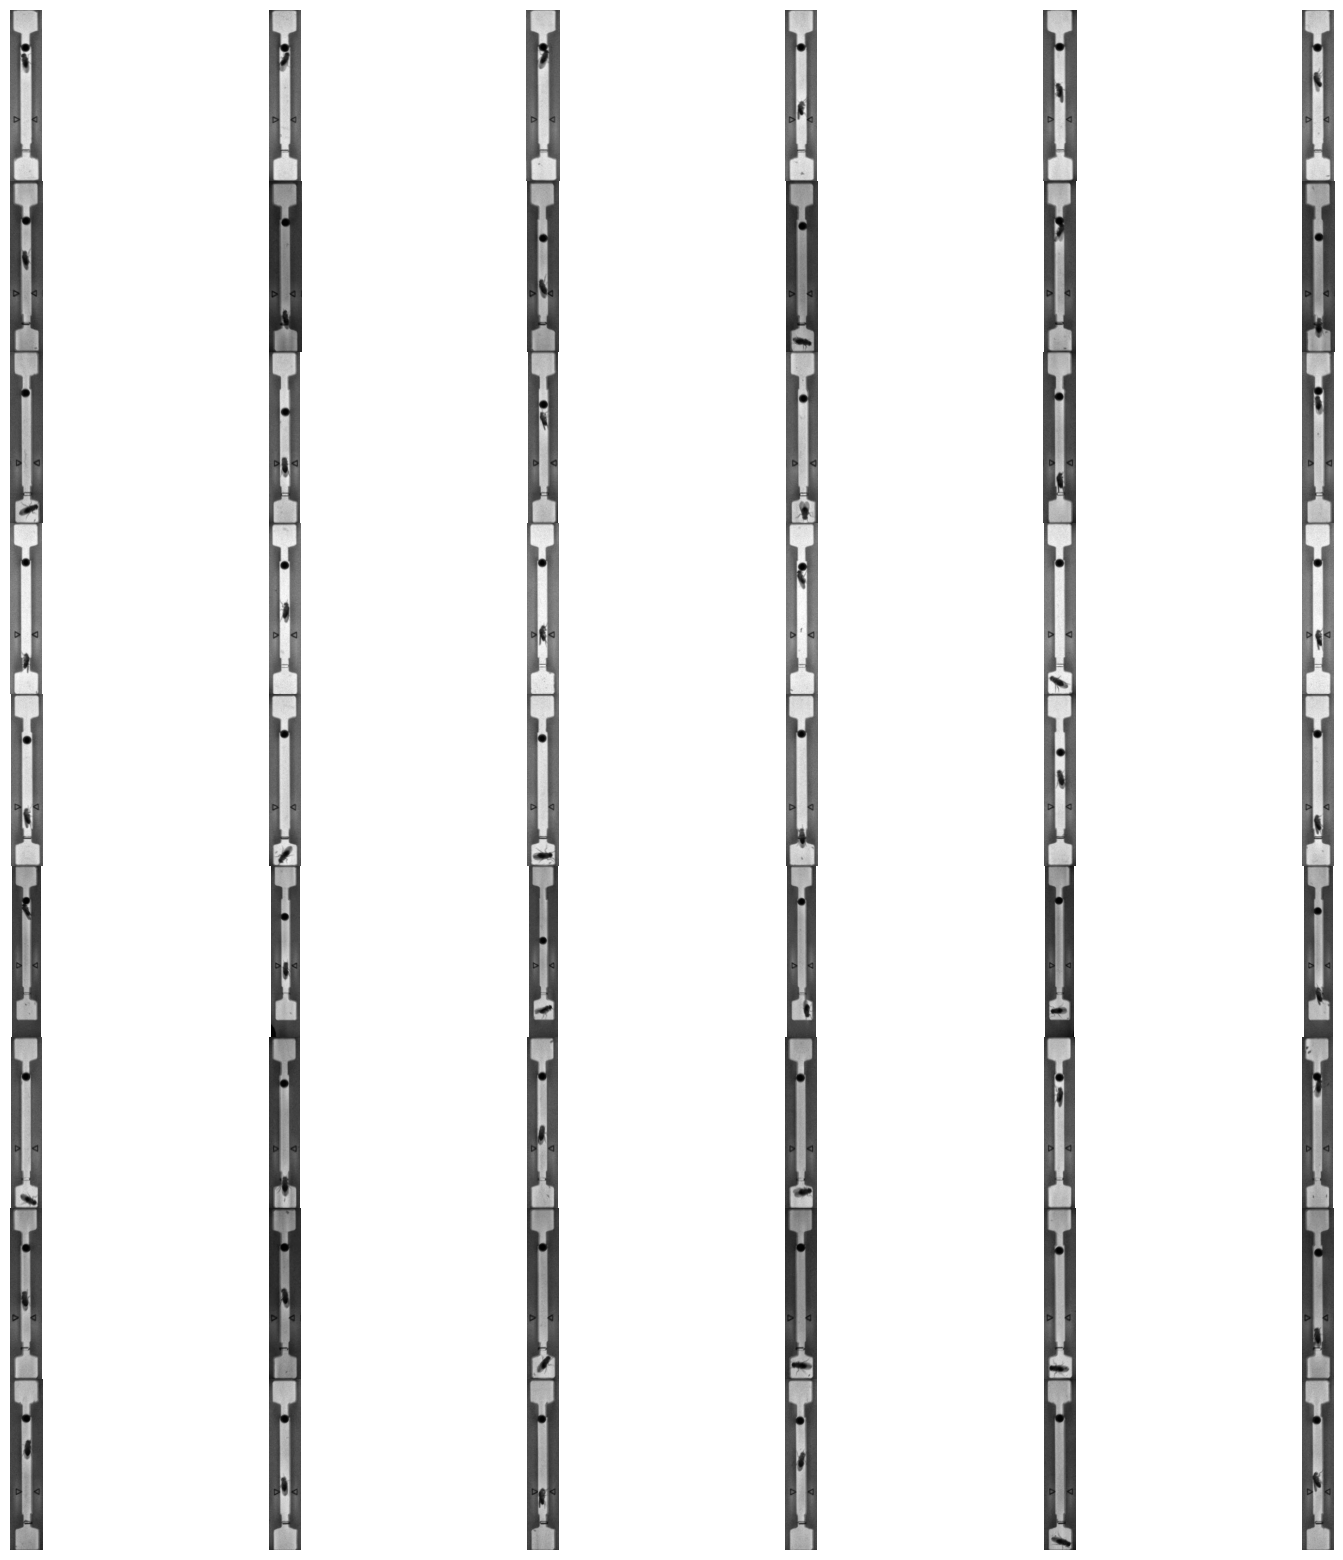

In [29]:
# Let's try instead to apply local histogram equalization to each frame

def apply_local_histogram_equalization(frame):
    """Apply local histogram equalization to a single frame."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_frame = clahe.apply(frame)
    return equalized_frame

# Apply local histogram equalization to each frame
equalized_frames = [apply_local_histogram_equalization(frame) for frame in frames]

# Plot the equalized grid
plot_grid(equalized_frames, paths)

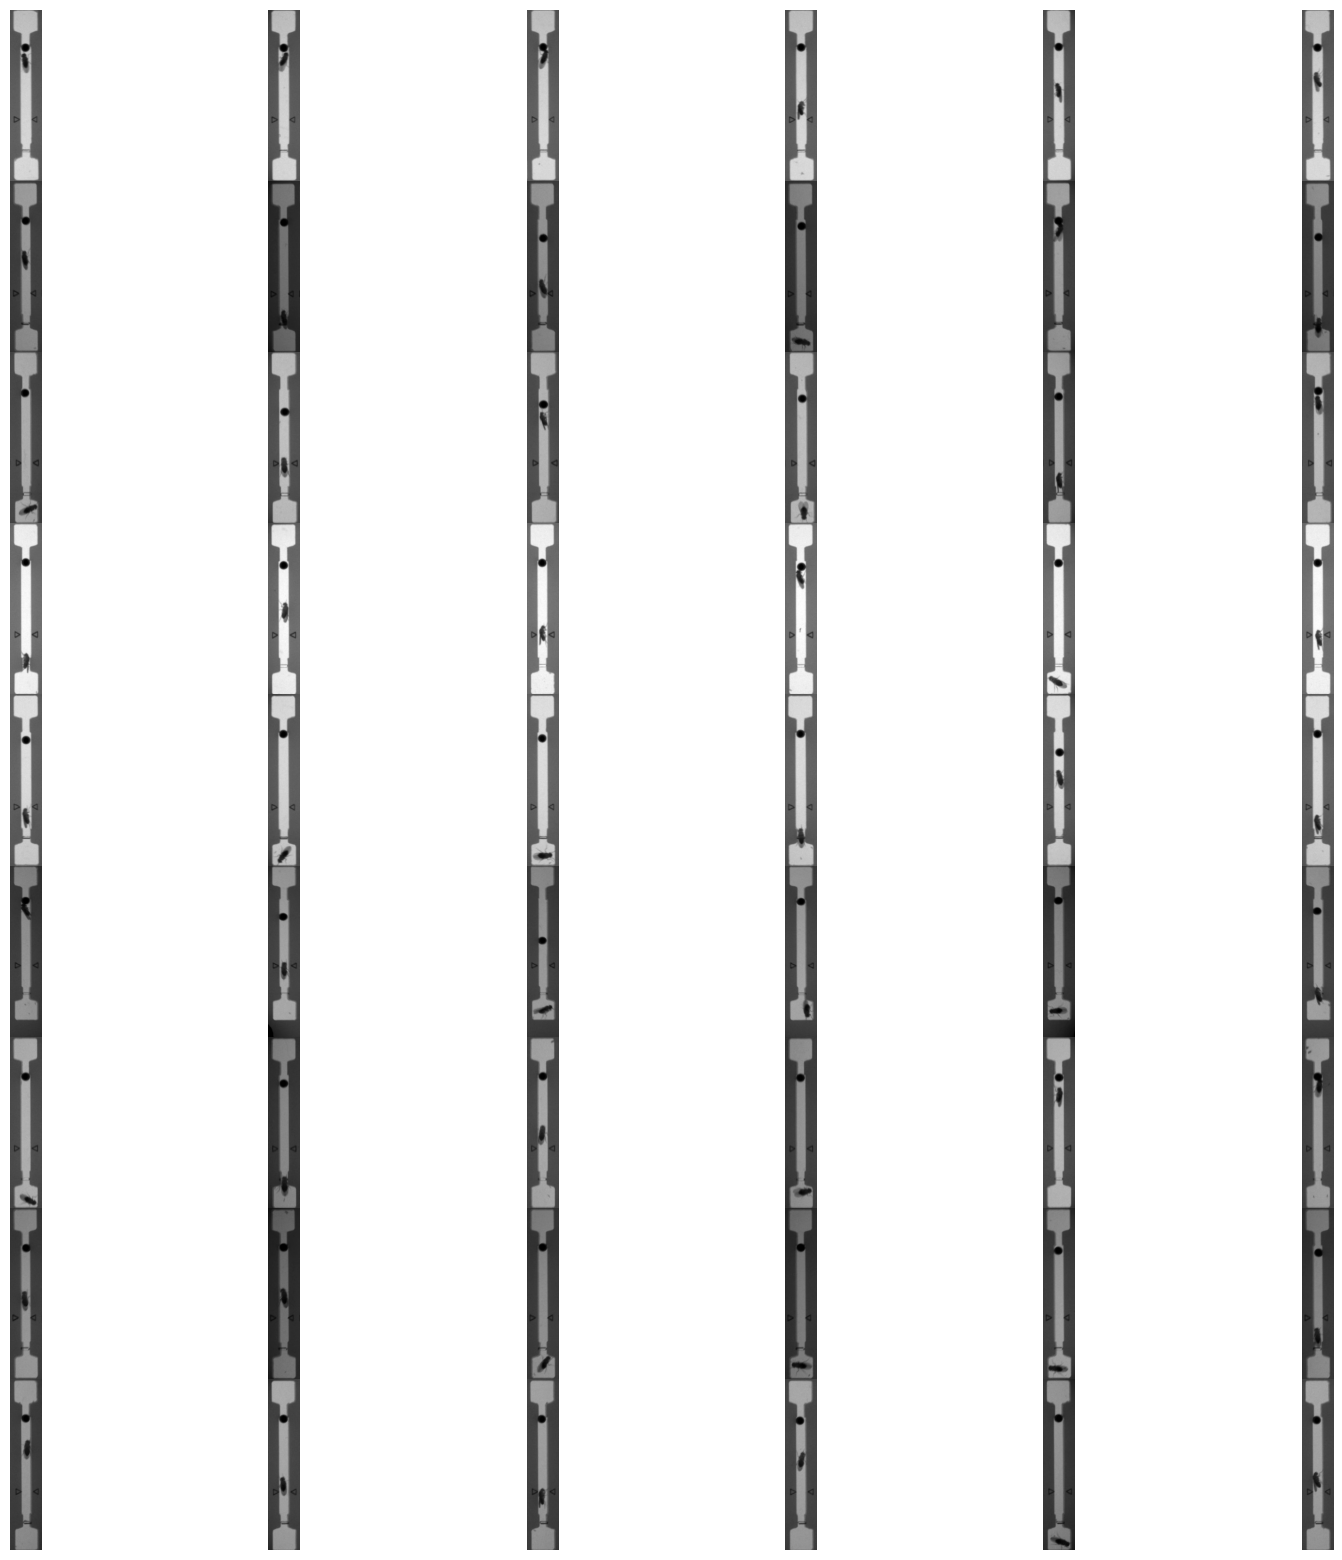

In [128]:
# Get the average size of the frames
heights = [frame.shape[0] for frame in frames]
widths = [frame.shape[1] for frame in frames]

avg_height = int(np.mean(heights))
avg_width = int(np.mean(widths))

# Resize all frames to the average size

def resize_frame(frame, avg_height, avg_width):
    
    resized_frame = cv2.resize(frame, (avg_width, avg_height))
    return resized_frame

# Resize all frames to the average size
resized_frames = [resize_frame(frame, avg_height, avg_width) for frame in frames]

# Plot the resized grid
plot_grid(resized_frames, paths)

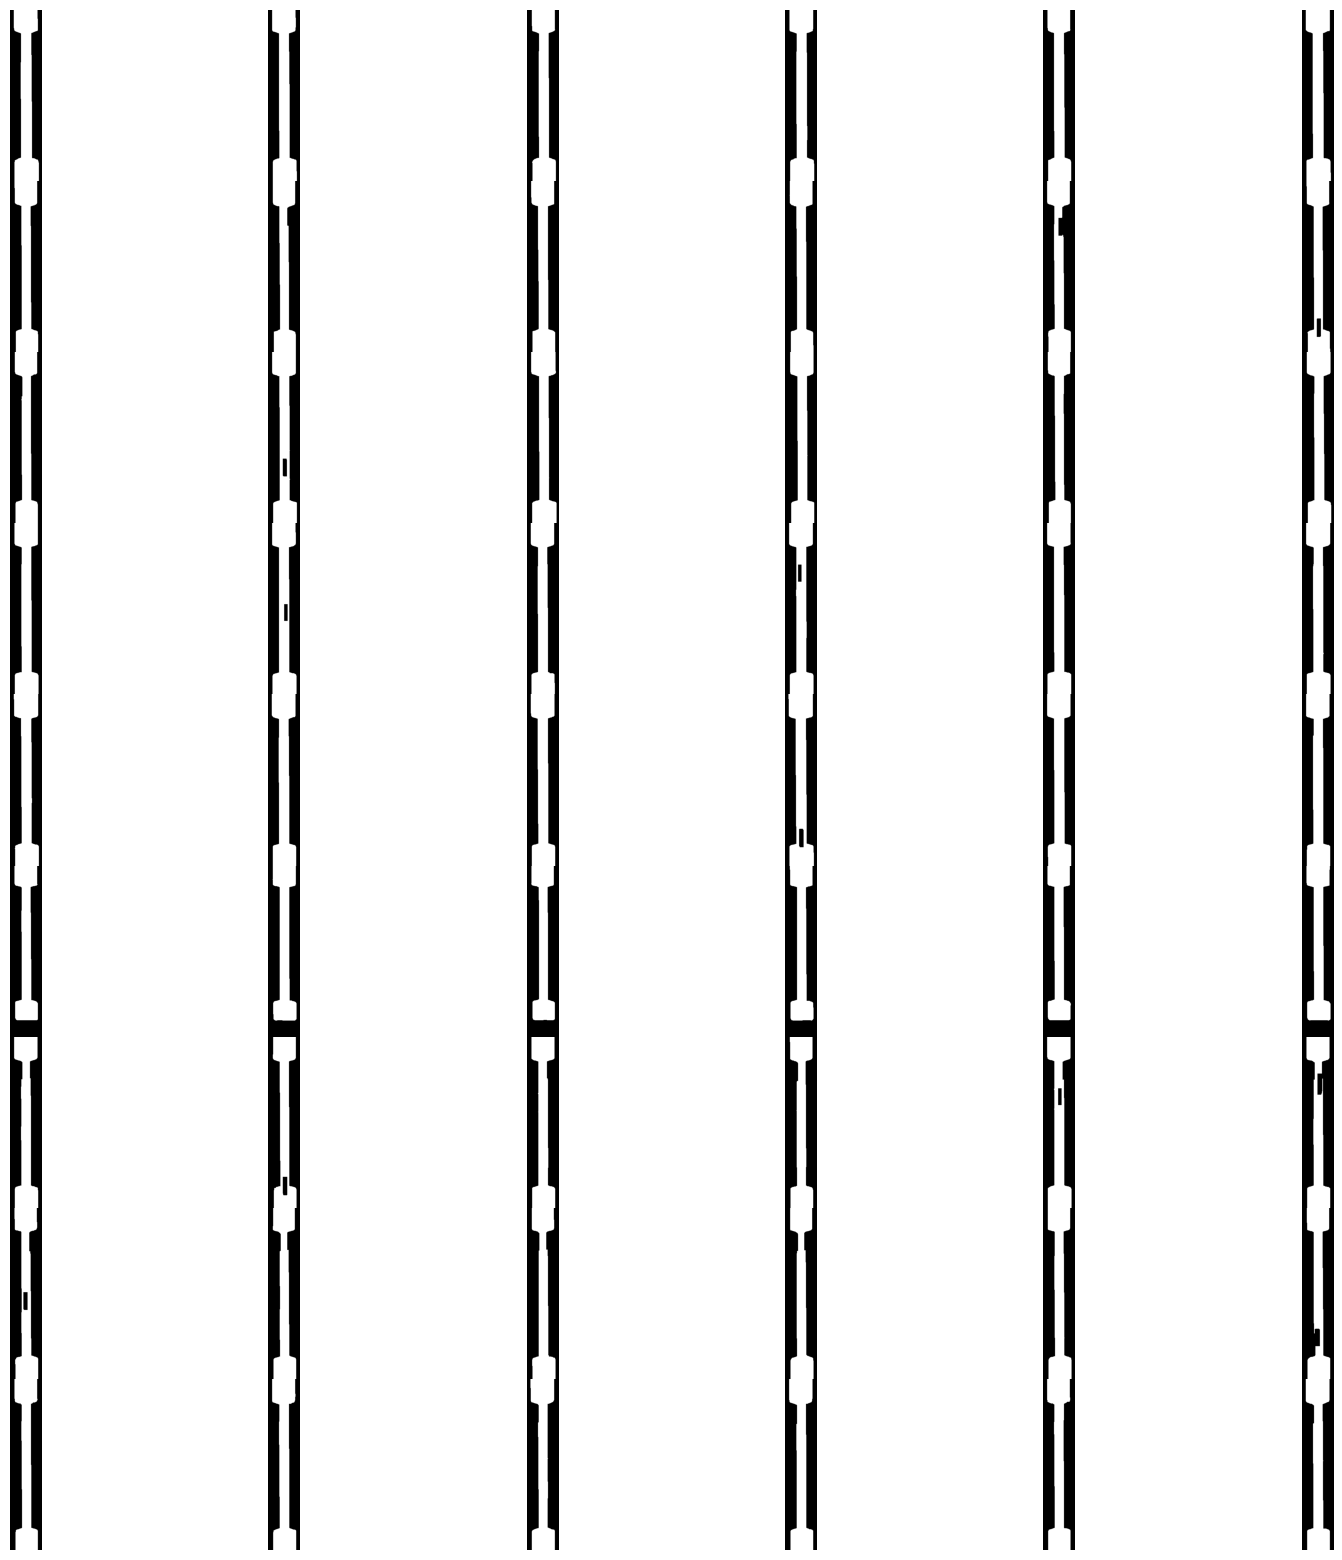

In [118]:
# Now we add a mask to the frames by detecting the corridors and masking the rest

def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    # binary = cv2.erode(binary, kernel, iterations=2)
    # binary = cv2.dilate(binary, kernel, iterations=3)

    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing

# Detect the corridors in each frame

binary_frames = [binarise(frame) for frame in resized_frames]

# Plot the corridor masks

plot_grid(binary_frames, paths)

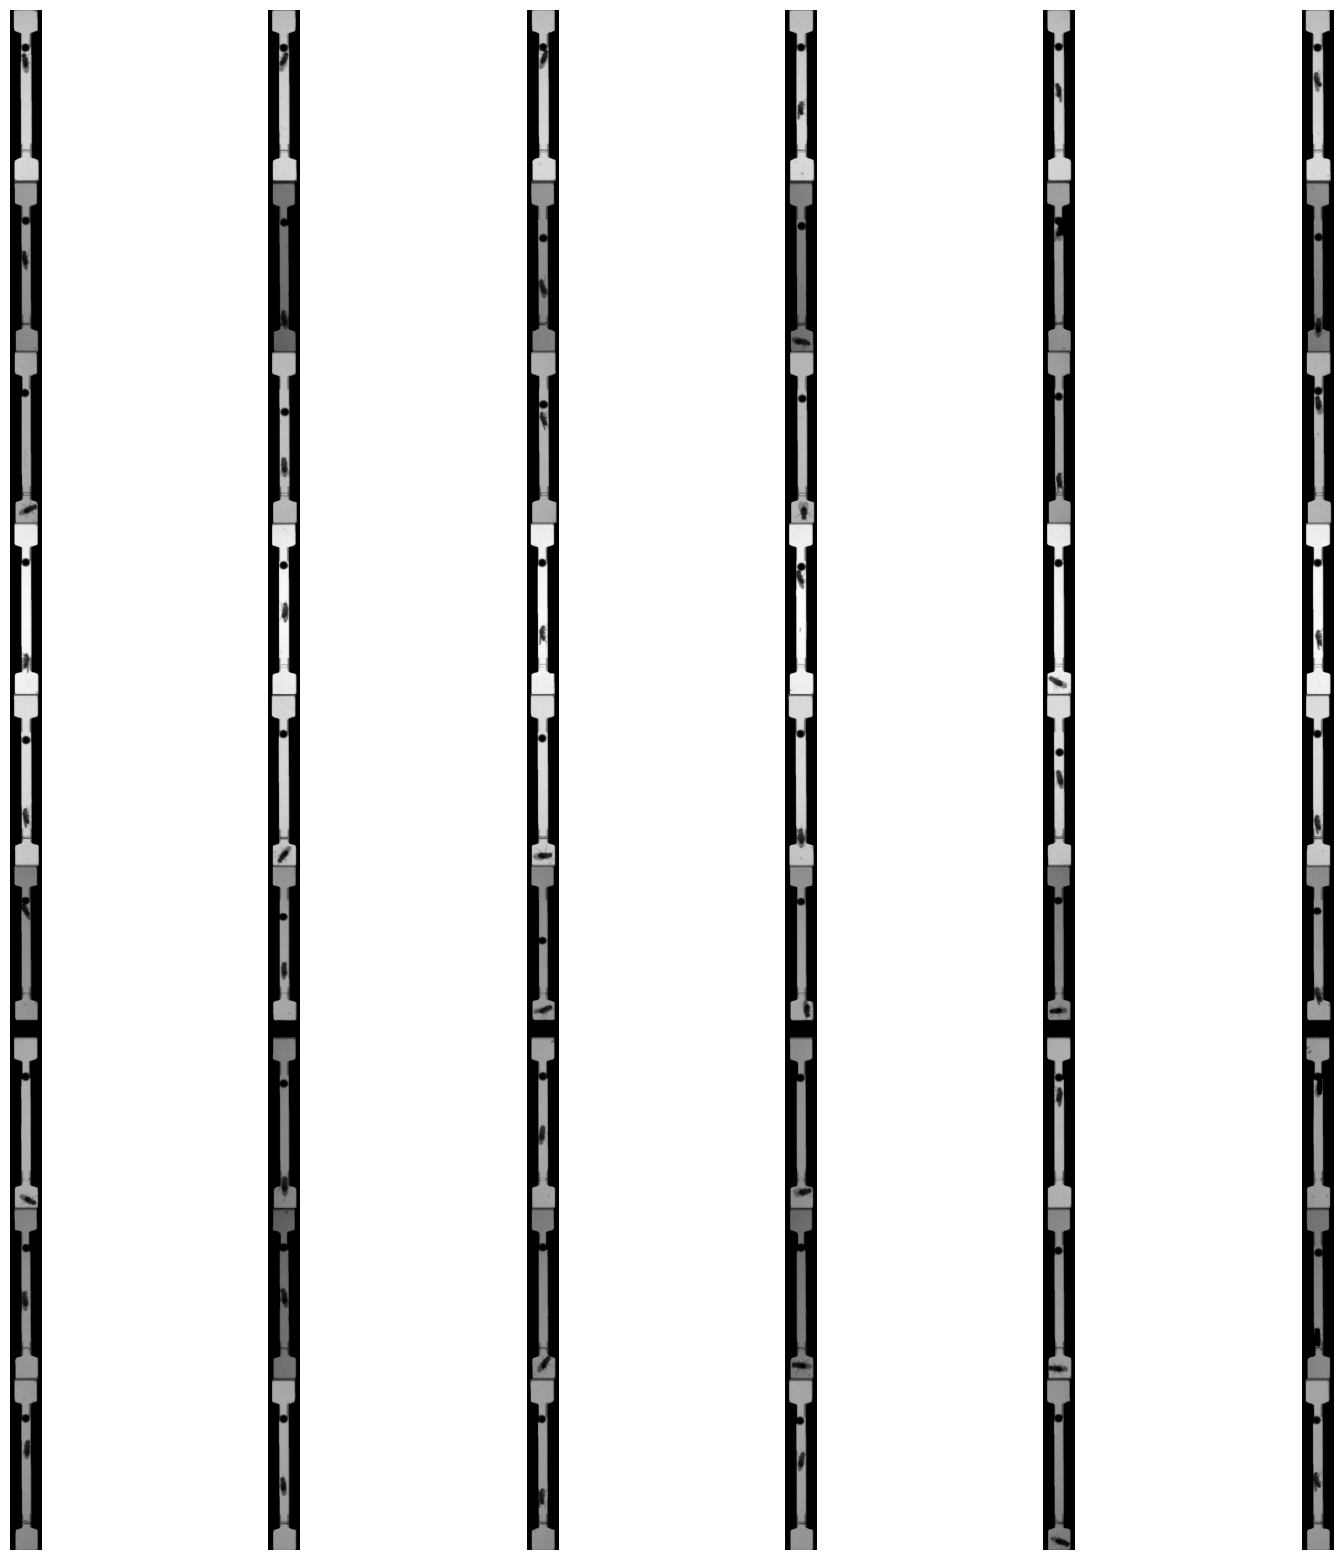

In [119]:
import cv2
import numpy as np


def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # kernel = np.ones((10,10),np.uint8)
    # closing = cv2.erode(binary, kernel, iterations=2)
    # closing = cv2.dilate(binary, kernel, iterations=2)

    return closing


def create_arena_mask(binary_frame):
    """Create a mask that keeps only the area inside the detected arena."""
    # Find contours in the binary frame
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Create an empty mask
    mask = np.zeros_like(binary_frame)

    # Assume the largest contour is the arena
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    return mask


def apply_arena_mask(frame, mask):
    """Apply the arena mask to the frame."""
    return cv2.bitwise_and(frame, frame, mask=mask)


# Detect the corridors in each frame and create masks
binary_frames = [binarise(frame) for frame in resized_frames]
arena_masks = [create_arena_mask(binary_frame) for binary_frame in binary_frames]

# Apply the masks to the original frames
masked_frames = [
    apply_arena_mask(frame, mask) for frame, mask in zip(resized_frames, arena_masks)
]

# Plot the masked frames
plot_grid(masked_frames, paths)

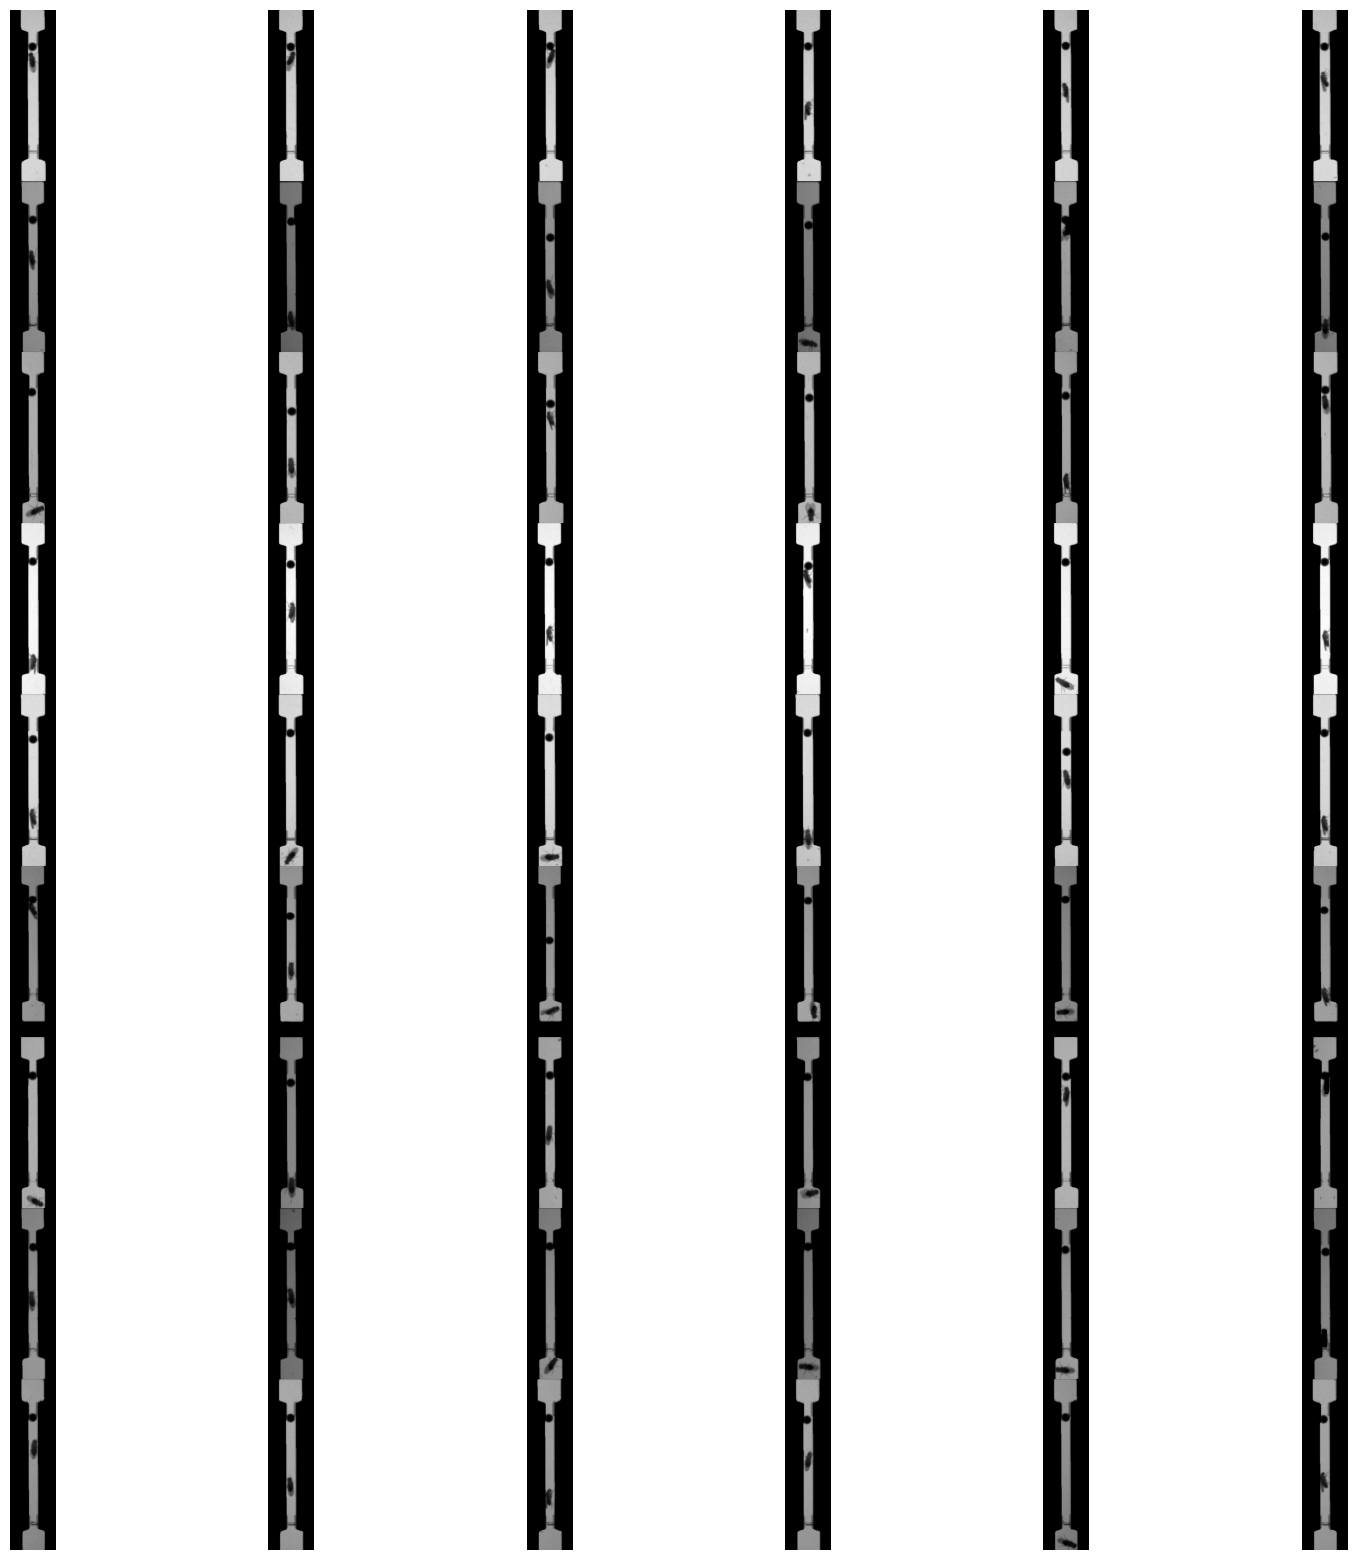

In [121]:
def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing


def create_arena_mask(binary_frame):
    """Create a mask that keeps only the area inside the detected arena."""
    # Find contours in the binary frame
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Create an empty mask
    mask = np.zeros_like(binary_frame)

    # Assume the largest contour is the arena
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    return mask


def apply_arena_mask(frame, mask):
    """Apply the arena mask to the frame and crop/pad the result."""
    # Apply the mask to the frame
    masked_frame = cv2.bitwise_and(frame, frame, mask=mask)

    # Crop 10 pixels from top and bottom
    cropped_frame = masked_frame[5:-5, :]

    # Add 10 pixels of black padding to the left and right
    padded_frame = cv2.copyMakeBorder(
        cropped_frame, 0, 0, 20, 20, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    return padded_frame


# Detect the corridors in each frame and create masks
binary_frames = [binarise(frame) for frame in resized_frames]
arena_masks = [create_arena_mask(binary_frame) for binary_frame in binary_frames]

# Apply the masks to the original frames
masked_frames = [
    apply_arena_mask(frame, mask) for frame, mask in zip(resized_frames, arena_masks)
]

# Plot the masked frames
plot_grid(masked_frames, paths)

In [72]:
# Now we apply connected component analysis to detect the corridors


def detect_corridors(frame):
    """Detect the corridors in a frame using connected component analysis."""
    # Find the connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(frame, connectivity=8)
    
    # Get the index of the largest connected component
    largest_component_idx = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    
    # Create a mask for the largest connected component
    corridor_mask = np.zeros_like(labels, dtype=np.uint8)
    corridor_mask[labels == largest_component_idx] = 255
    
    return corridor_mask

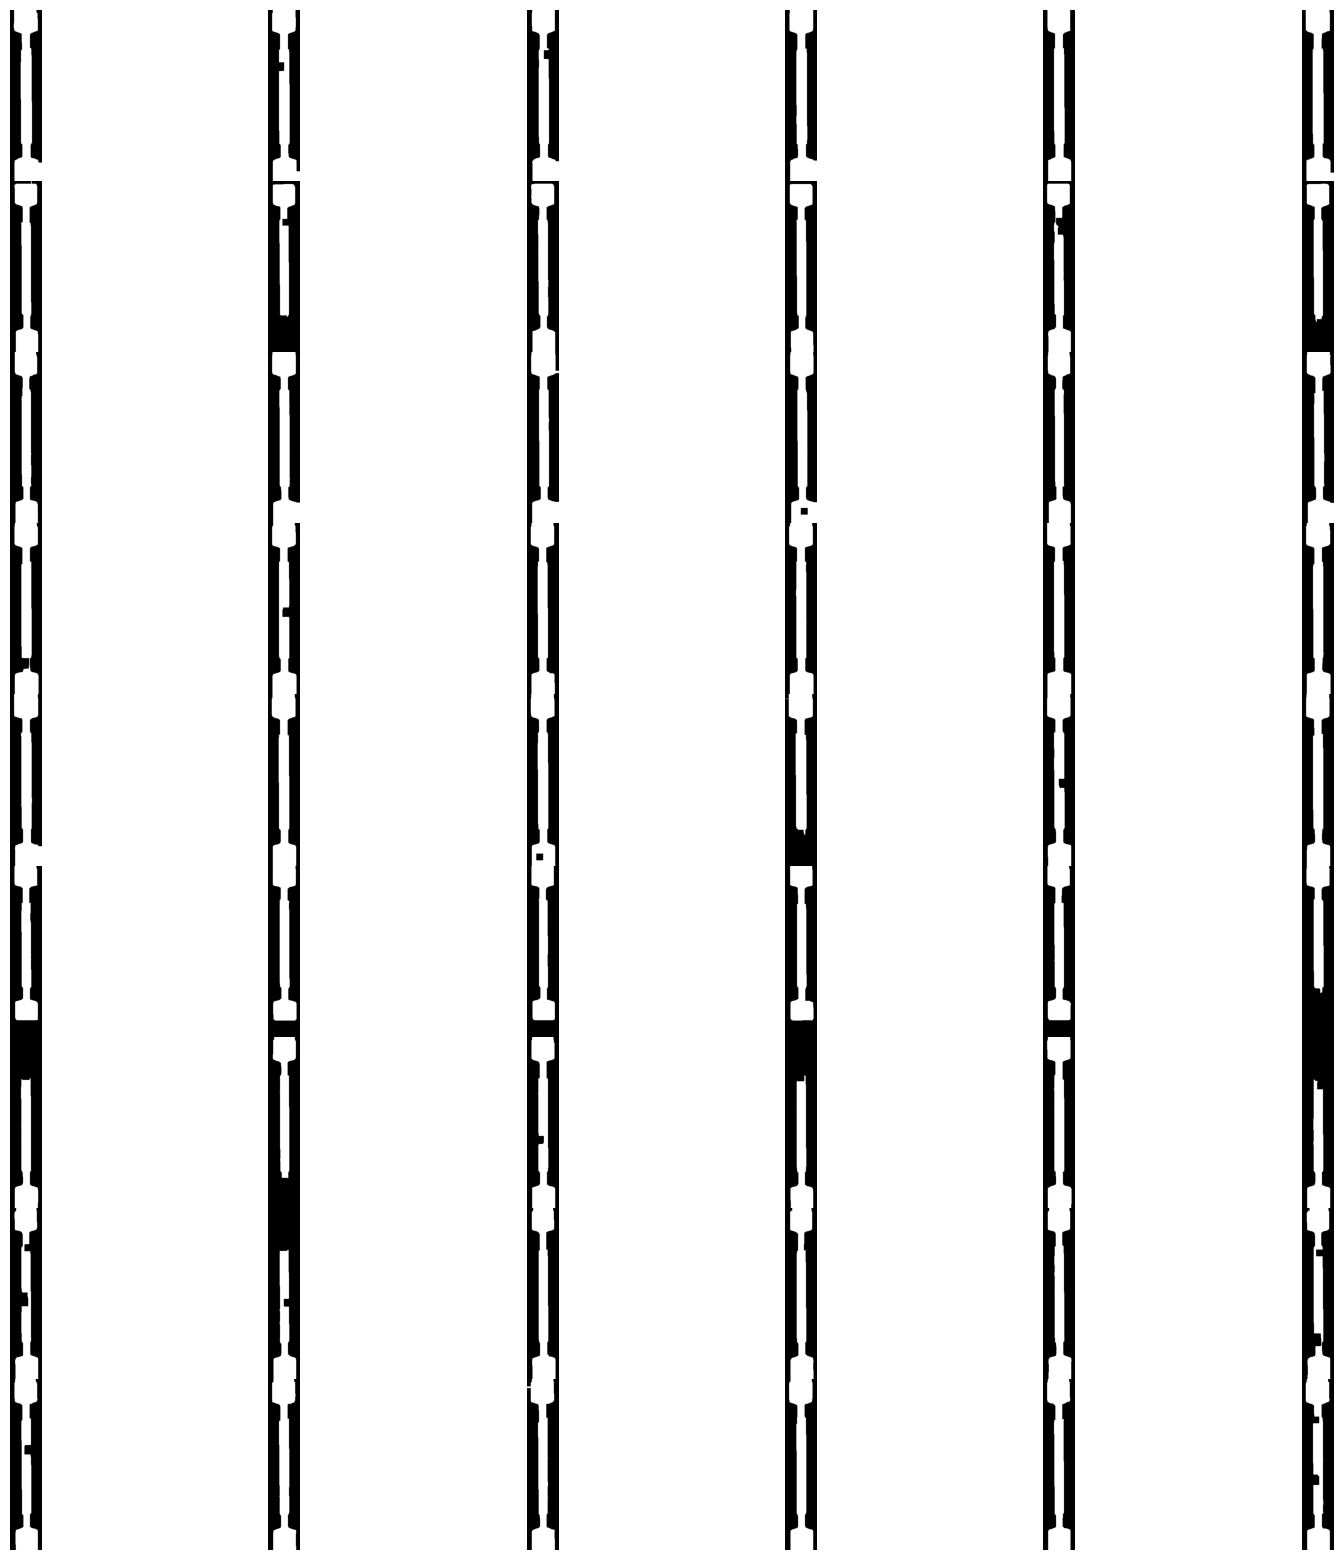

In [73]:
# Detect the corridors in each frame
corridor_masks = [detect_corridors(frame) for frame in binary_frames]

# Plot the corridor masks
plot_grid(corridor_masks, paths)

In [75]:
# Let's try to use background subtraction to detect the corridors


def background_subtraction(frame, video_path):
    """Detect the corridors in a frame using background subtraction."""
    # Create a background subtractor
    bg_subtractor = cv2.createBackgroundSubtractorMOG2()

    # Open the video
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    # Get the total number of frames in the video
    total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get the random frames
    random_frames = np.random.randint(0, total_frames, 300)

    # Generate the background model using the random frames
    for i in random_frames:
        vid.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, random_frame = vid.read()
        if not ret:
            print(f"Error: Could not read frame {i} for video {video_path}")
            continue
        bg_subtractor.apply(random_frame)

    # Release the video capture object
    vid.release()

    # Apply background subtraction to the frame
    corridor_mask = bg_subtractor.apply(frame)

    return corridor_mask


def grid_background_subtraction(frames, paths):
    """Apply background subtraction to each frame using corresponding video paths."""
    corridor_masks = []

    for i, frame in enumerate(frames):
        corridor_mask = background_subtraction(frame, paths[i])
        if corridor_mask is not None:
            corridor_masks.append(corridor_mask)

    return corridor_masks




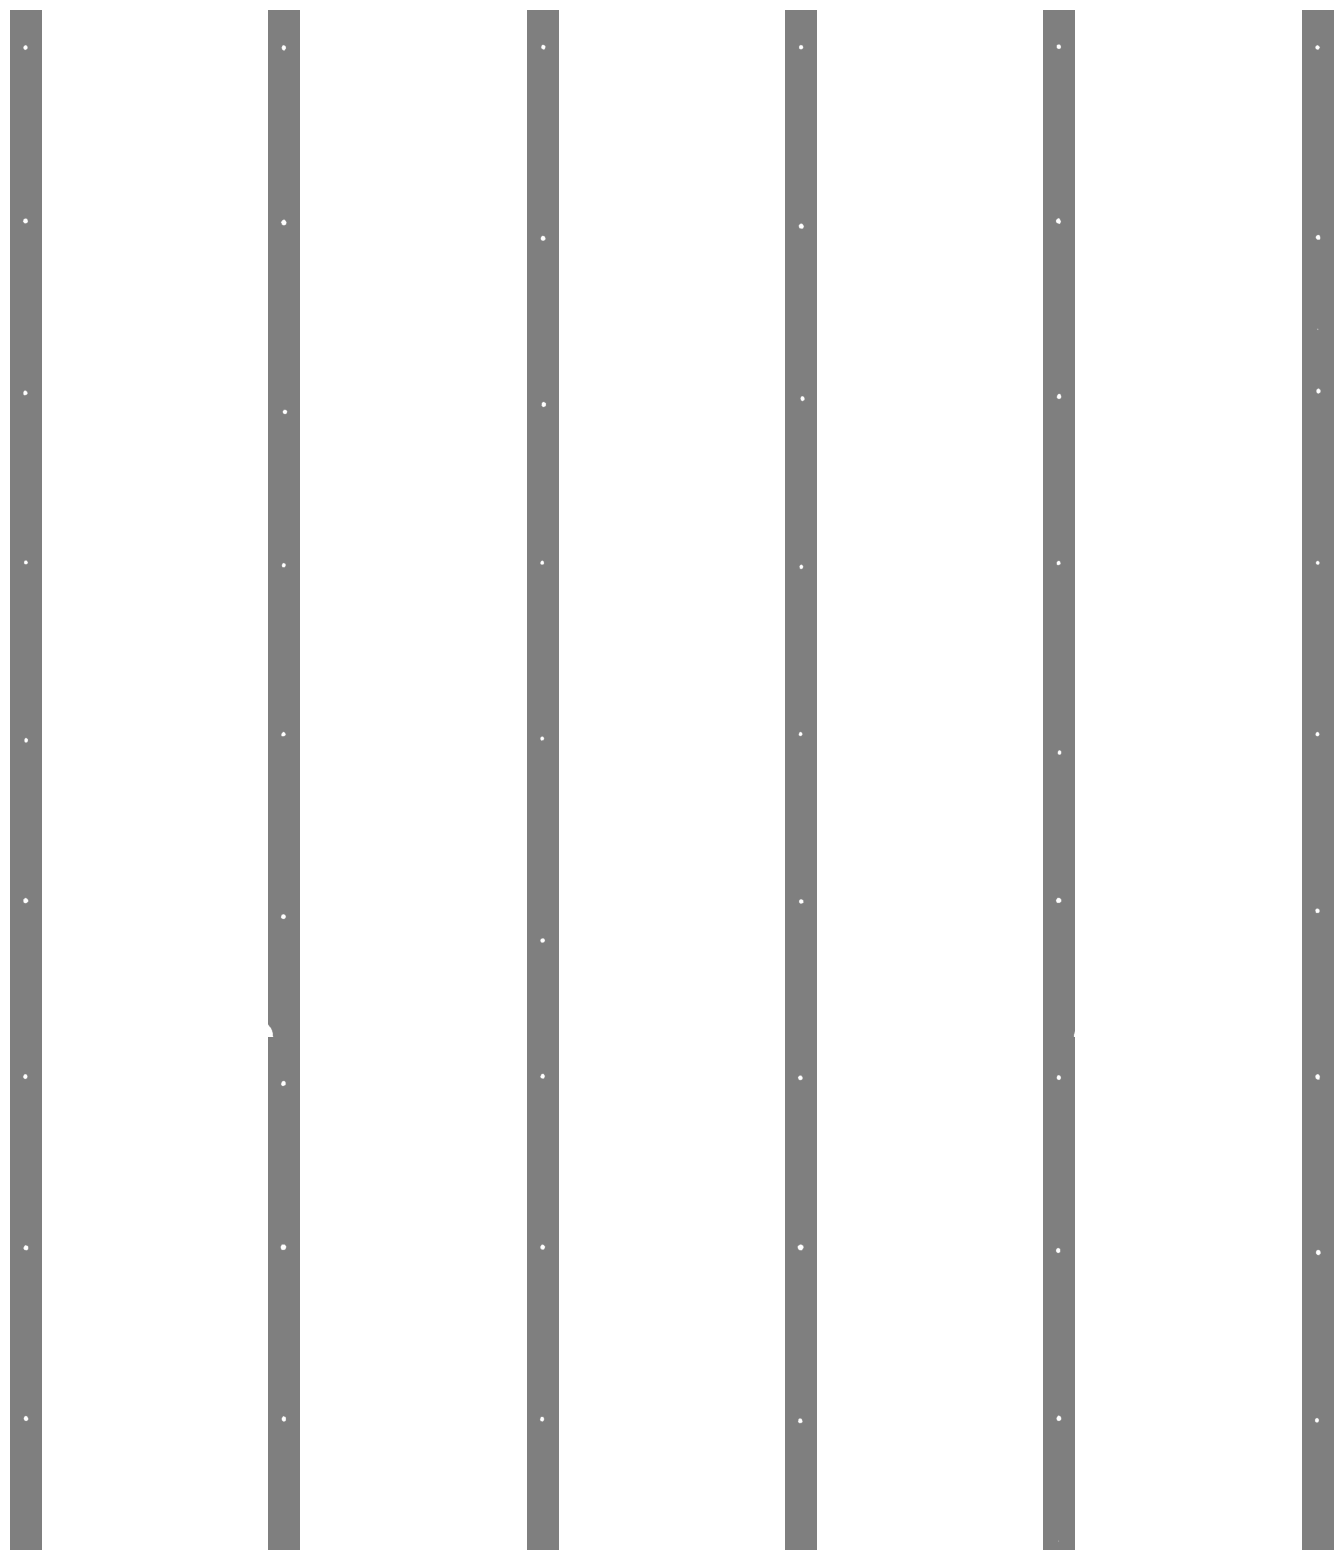

In [80]:
# Example usage
# Assuming `resized_frames` and `paths` are defined
corridor_masks = grid_background_subtraction(resized_frames, paths)

# Plot the corridor masks
plot_grid(corridor_masks, paths)

# 1 step preprocessing

Here we regroup all relevant stuff for one given frame

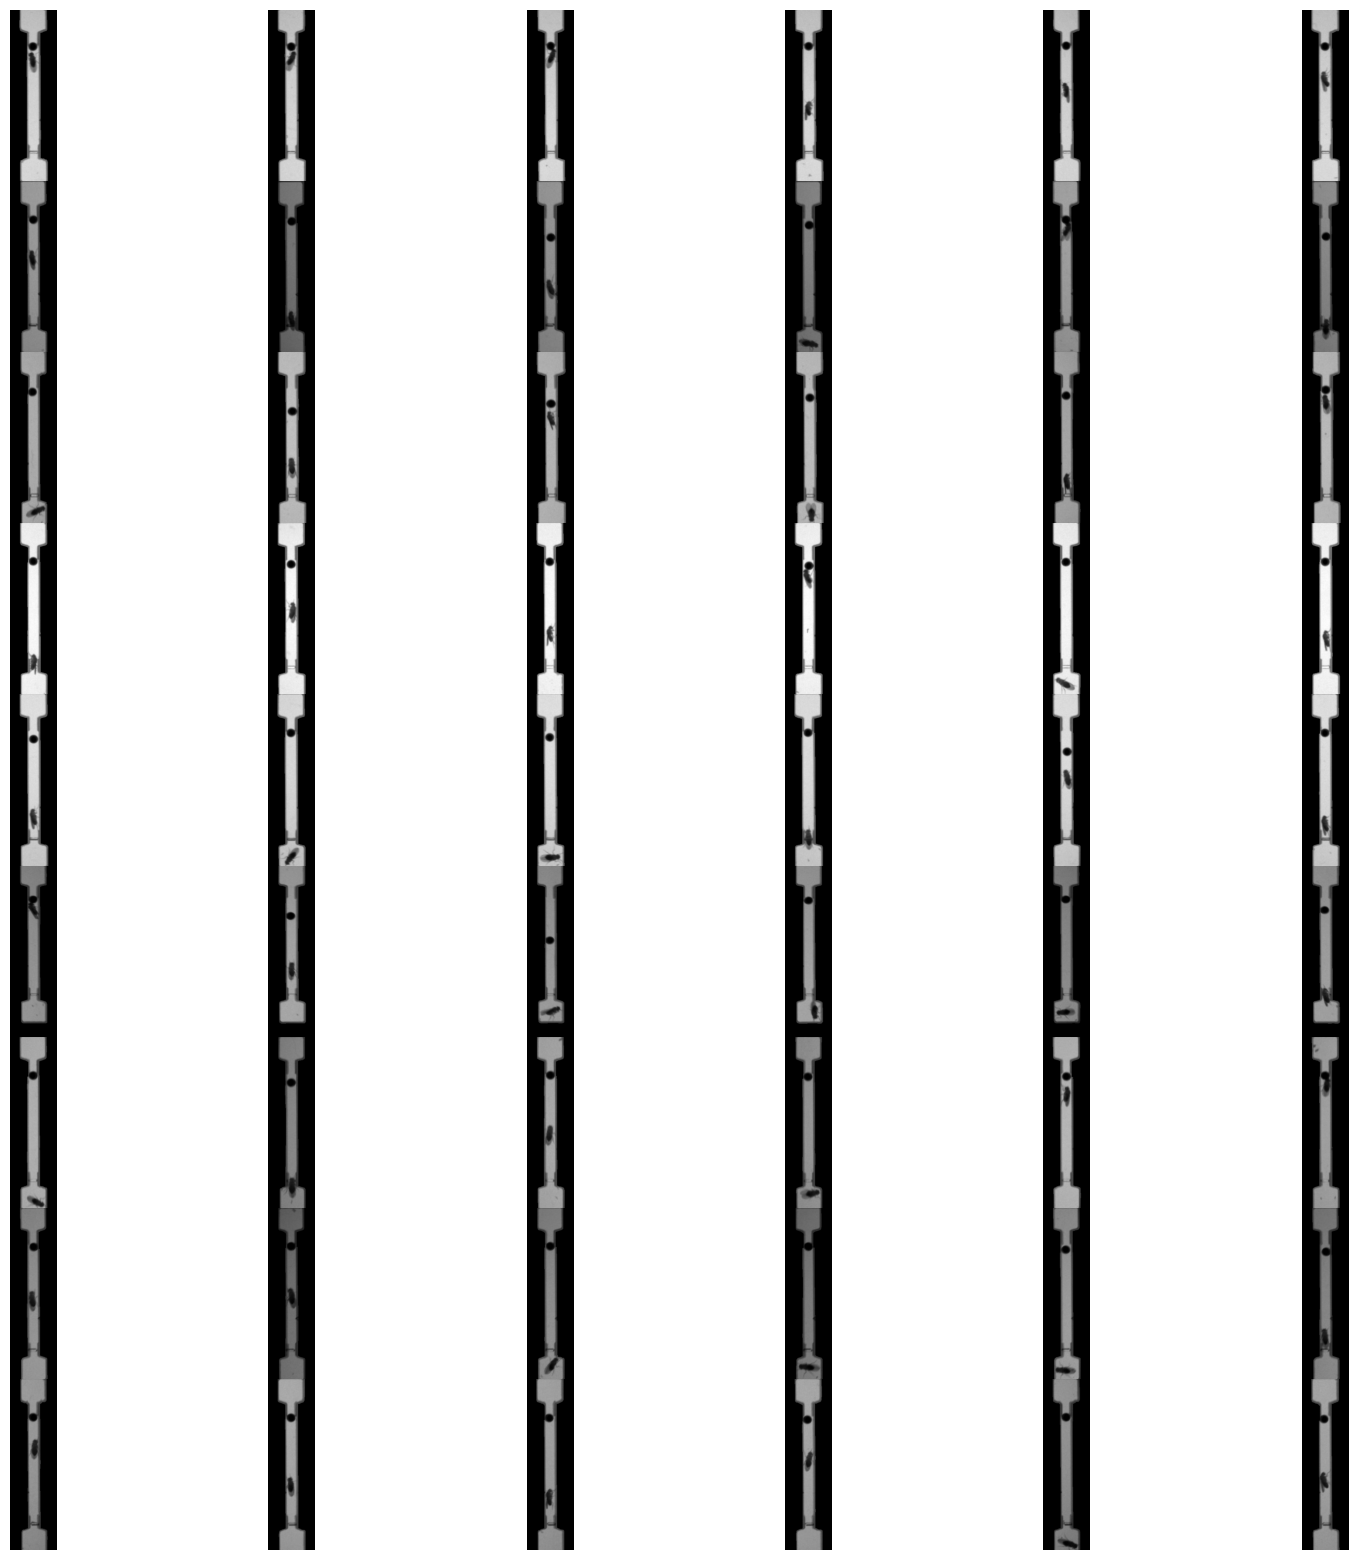

In [139]:
def resize_frame(frame, width, height):
    """Resize the frame to the given width and height."""
    return cv2.resize(frame, (width, height))


def equalize_histogram(frame):
    """Apply adaptive histogram equalization to the frame."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(frame)


def binarise(frame):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Add some erosion and dilation to remove noise
    kernel = np.ones((50, 10), np.uint8)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return closing


def create_arena_mask(binary_frame):
    """Create a mask that keeps only the area inside the detected arena."""
    # Find contours in the binary frame
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Create an empty mask
    mask = np.zeros_like(binary_frame)

    # Assume the largest contour is the arena
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the largest contour on the mask
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    return mask


def apply_arena_mask(frame, mask, dilation_iterations=2):
    """Apply the arena mask to the frame and crop/pad the result."""
    # Dilate the mask to make it slightly larger
    kernel = np.ones((5, 5), np.uint8)  # Adjust the kernel size as needed
    dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)

    # Apply the dilated mask to the frame
    masked_frame = cv2.bitwise_and(frame, frame, mask=dilated_mask)

    # Crop 10 pixels from top and bottom
    cropped_frame = masked_frame[6:-6, :]

    # Add 10 pixels of black padding to the left and right
    padded_frame = cv2.copyMakeBorder(
        cropped_frame, 0, 0, 20, 20, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    return padded_frame


def preprocess_frame(frame, width, height):
    """Preprocess the frame by resizing, equalizing histogram, binarizing, and applying mask."""
    resized_frame = resize_frame(frame, width, height)
    equalized_frame = equalize_histogram(resized_frame)
    binary_frame = binarise(equalized_frame)
    arena_mask = create_arena_mask(binary_frame)
    final_frame = apply_arena_mask(resized_frame, arena_mask)
    return final_frame


# Template size
template_width = 96
template_height = 516

# Preprocess each frame
preprocessed_frames = [
    preprocess_frame(frame, template_width, template_height) for frame in resized_frames
]

# Plot the preprocessed frames
plot_grid(preprocessed_frames, paths)

# Translate annotated labels

In [133]:
import random

def resize_labels(labels, original_width, original_height, new_width, new_height):
    """Resize the labels according to the new frame size."""
    x_scale = new_width / original_width
    y_scale = new_height / original_height
    return [(int(x * x_scale), int(y * y_scale)) for x, y in labels]

def apply_arena_mask_to_labels(labels):
    """Adjust the labels according to the cropping and padding applied to the frame."""
    # Crop 10 pixels from top and bottom
    cropped_labels = [(x, y - 6) for x, y in labels if 6 <= y < 510]

    # Add 10 pixels of black padding to the left and right
    padded_labels = [(x + 20, y) for x, y in cropped_labels]

    return padded_labels

def preprocess_labels(labels, original_width, original_height, new_width, new_height):
    """Preprocess the labels by resizing and applying mask transformations."""
    resized_labels = resize_labels(labels, original_width, original_height, new_width, new_height)
    final_labels = apply_arena_mask_to_labels(resized_labels)
    return final_labels

def generate_random_labels(frame, num_labels=10):
    """Generate random labels within the bounds of the frame."""
    height, width = frame.shape[:2]
    return [(random.randint(0, width - 1), random.randint(0, height - 1)) for _ in range(num_labels)]

def plot_frames_with_labels(frames, labels_list, title):
    """Plot frames with their corresponding labels."""
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for ax, frame, labels in zip(axes, frames, labels_list):
        ax.imshow(frame, cmap='gray')
        for x, y in labels:
            ax.plot(x, y, 'ro')
        ax.axis('off')
    fig.suptitle(title)
    plt.show()


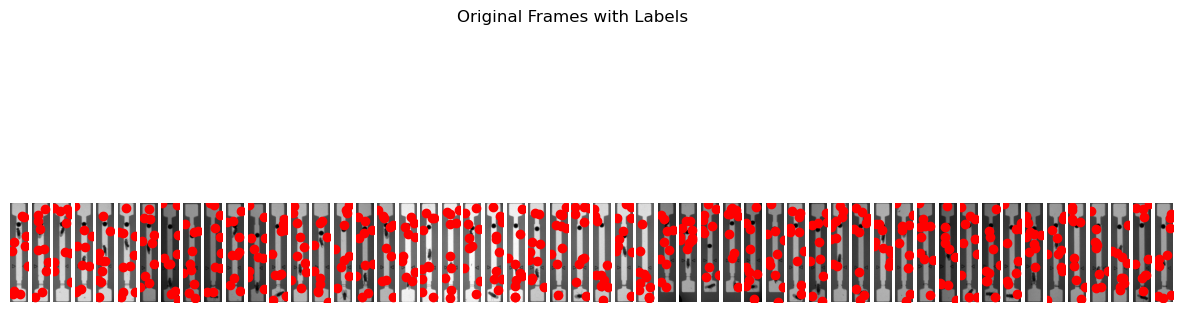

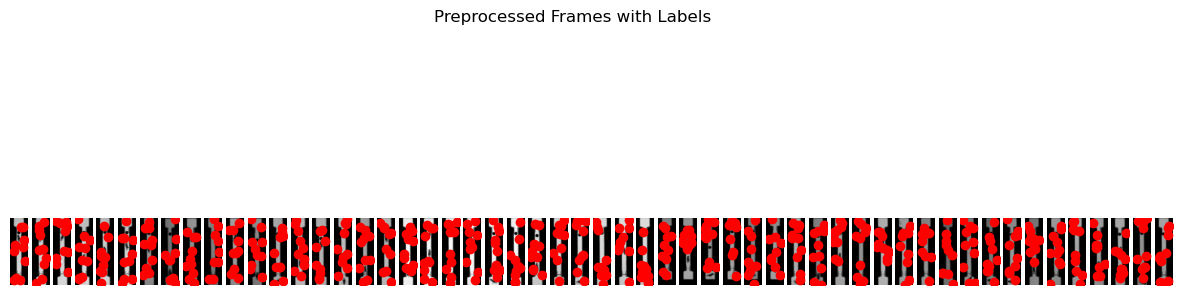

In [147]:
# Example usage with frames and random labels
tracking_labels = [generate_random_labels(frame) for frame in resized_frames]

original_width, original_height = resized_frames[0].shape[1], resized_frames[0].shape[0]
preprocessed_labels = [
    preprocess_labels(
        labels, original_width, original_height, template_width, template_height
    )
    for labels in tracking_labels
]

# Plot the original and preprocessed frames with labels
plot_frames_with_labels(resized_frames, tracking_labels, "Original Frames with Labels")
plot_frames_with_labels(
    preprocessed_frames, preprocessed_labels, "Preprocessed Frames with Labels"
)

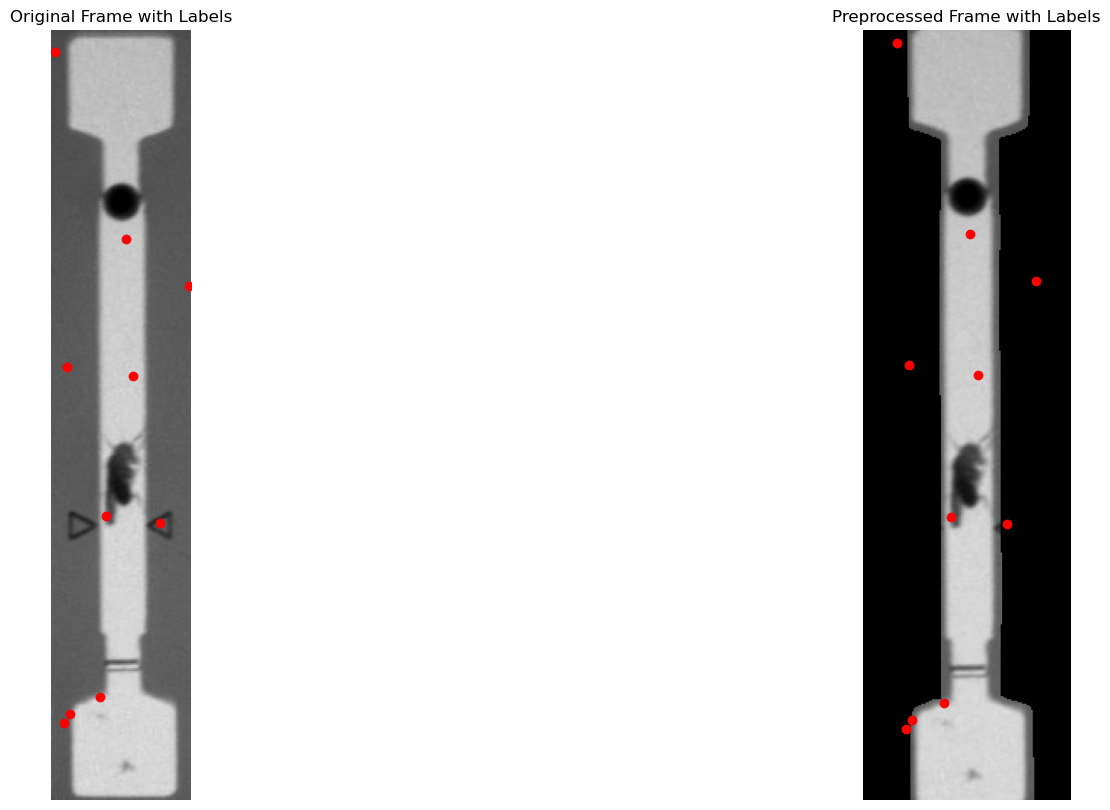

In [148]:
def display_frame_with_labels(
    original_frame, preprocessed_frame, original_labels, preprocessed_labels
):
    """Display a single frame with and without preprocessing along with their labels in a larger format."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Display original frame with labels
    axes[0].imshow(original_frame, cmap="gray")
    for x, y in original_labels:
        axes[0].plot(x, y, "ro")
    axes[0].set_title("Original Frame with Labels")
    axes[0].axis("off")

    # Display preprocessed frame with labels
    axes[1].imshow(preprocessed_frame, cmap="gray")
    for x, y in preprocessed_labels:
        axes[1].plot(x, y, "ro")
    axes[1].set_title("Preprocessed Frame with Labels")
    axes[1].axis("off")

    plt.show()


# Example usage with the first frame and its labels

frame_id = 3

original_frame = resized_frames[frame_id]
preprocessed_frame = preprocessed_frames[frame_id]
original_labels = tracking_labels[frame_id]
preprocessed_labels = preprocessed_labels[frame_id]

display_frame_with_labels(
    original_frame, preprocessed_frame, original_labels, preprocessed_labels
)